# Debut

In [8]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z, new_post_pdf_z, post_sample
from sbibm.metrics import c2st
import torch
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
@jit
def prior_simulator(key):
    key, key_mu, key_sigma = random.split(key, 3)
    sigma2 = 1/random.gamma(key_sigma, A_IG, shape=(1,))*B_IG
    mu = random.normal(key_mu, (1,))*jnp.sqrt(sigma2/TAU) + MU0
    return jnp.array([mu[0], sigma2[0]])


@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*jnp.sqrt(theta[1]) + theta[0]).astype(float)

@jit
def discrepancy(y, y_true):
    return jnp.sum((jnp.sort(y) - jnp.sort(y_true))**2)

# def true_post(z):
#     mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
#     sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
#     return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


In [9]:
A_IG, B_IG = 3, 10
MU0, TAU = 0, .05
N_DATA = 50
key = random.PRNGKey(8)
key, key_prior, key_data = random.split(key, 3)
TRUE_THETA = prior_simulator(key_prior)
TRUE_DATA = data_simulator(key_data, TRUE_THETA)

print("TRUE_MU:", TRUE_THETA[0], "TRUE_SIGMA2:", TRUE_THETA[1])

TRUE_MU: 7.312621 TRUE_SIGMA2: 20.45967


In [3]:
def NIG_sample(key, size):
    key, key_mu, key_sigma = random.split(key, 3)
    sigma2 = 1/random.gamma(key_sigma, A_IG, shape=(size,))*B_IG
    mu = random.normal(key_mu, (size,))*jnp.sqrt(sigma2)/TAU + MU0
    return np.array([mu, sigma2])



In [4]:
A_IG, B_IG = 3, 10
MU0, TAU = 0, .05
print("Variance mu = ", B_IG/(A_IG-1)/TAU)
print("Variance sigma = ", B_IG**2/(A_IG-1)**2/(A_IG-2))
mus, sigmas2 = NIG_sample(key, 100000)


Variance mu =  100.0
Variance sigma =  25.0


In [5]:
# def true_post_sample(data,size):
#     n = len(data)
#     mu_post = (TAU*MU0+np.sum(data))/(TAU+n)
#     tau_post = TAU+n
#     a_post = A_IG + n/2
#     b_post = B_IG + 1/2*np.sum((data-MU0)**2)*n*TAU/(TAU+n)
#     SIGMAS = 1/stats.gamma.rvs(a_post, size = size)*b_post
#     return stats.norm(loc = mu_post, scale = np.sqrt(SIGMAS/tau_post)).rvs(size)

def true_post_sample(key, data, size):
    n = len(data)
    mu_post = (TAU*MU0+np.sum(data))/(TAU+n)
    tau_post = TAU+n
    a_post = A_IG + n/2
    b_post = B_IG + 1/2*np.sum((data-MU0)**2)*n*TAU/(TAU+n)
    return random.t(key, 2*a_post, shape = (size,))*jnp.sqrt(b_post/(a_post*tau_post))+mu_post

In [6]:



def true_ratio_z(mus, z, prior, posterior):
    return posterior(z).pdf(mus)/prior.pdf(mus)

def true_decision_z(mus, z, prior, posterior):
    return 1/(1+1/true_ratio_z(mus, z, prior, posterior))

def true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior):
    pseudo = true_pseudo_post(mus, bar_xobs, epsilon, prior)
    Z_pseudo = np.trapz(pseudo, mus)
    return posterior(z).pdf(mus)/pseudo*Z_pseudo

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

# def true_pseudo_post(mus, bar_xobs, epsilon, prior):
    # return prior.pdf(mus)*(norm.cdf(bar_xobs+np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)) - norm.cdf(bar_xobs-np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)))

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def decision_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_z(params, mus, z)))
def decision_batch_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_batch_z(params, mus, z)))


In [7]:
TRUE_DATA

Array([15.634385 , 13.61311  ,  7.980258 ,  5.892979 ,  9.622666 ,
        5.7574487,  9.103623 ,  6.288876 ,  5.3904753,  9.314126 ,
        7.7840643,  3.3795216,  9.736733 , 11.282849 , 14.594194 ,
       13.006074 ,  7.317129 ,  9.636893 , 10.92065  ,  7.166588 ,
        7.108946 ,  5.613342 ,  2.9765117, 16.401955 , 10.903137 ,
        9.687882 , 12.78488  , 11.535805 ,  4.3116026, 11.243576 ,
        2.5205095, -5.5818925,  1.59092  ,  7.9518495, 11.3845625,
        5.7068386,  9.865933 ,  3.2729065,  5.7413564, 14.08298  ,
       10.292571 ,  2.7442224, 13.2751255,  6.6205096,  9.252688 ,
        2.6144354, -1.1982528, -2.3485513,  8.7344475,  7.159534 ],      dtype=float32)

In [ ]:

ALPHAS = [1., .99, .9,  .5, .1, .01]
N_POINTS_EPS = 22000000

key = random.PRNGKey(0)
zs, thetas, dists, key = ABC_epsilon(key, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, np.inf, TRUE_DATA)
mus = thetas[:,0]
            
EPSILONS = {1.: jnp.inf}
for alpha in ALPHAS[1:]:
    EPSILONS[alpha] = np.quantile(dists, alpha)
    


In [ ]:
ALPHAS = [1., .99, .9,  .5, .1, .01]
for ALPHA in ALPHAS:
    EPSILON = EPSILONS[ALPHA]
    X_train,

(2.3126211166381836, 12.312621116638184)

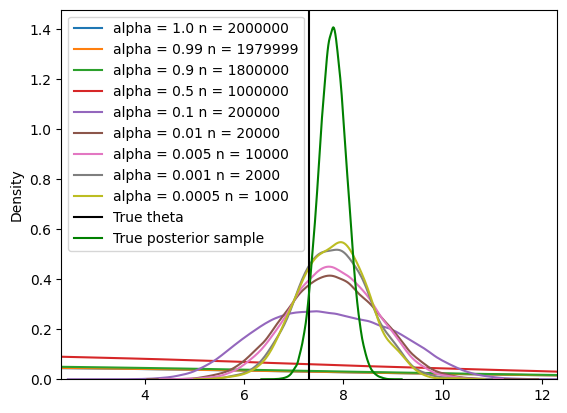

In [9]:
for alpha in ALPHAS:
    sns.kdeplot(mus[dists< EPSILONS[alpha]], label = f"alpha = {alpha} n = {np.sum(dists < EPSILONS[alpha])}")
plt.axvline(TRUE_THETA[0], color = "black", label = "True theta")
true_sample = true_post_sample(key, TRUE_DATA, 100000)
sns.kdeplot(true_sample, label = "True posterior sample", color = "green")
plt.legend()
plt.xlim(TRUE_THETA[0]-5, TRUE_THETA[0]+5)

In [10]:
np.unique(np.unique(mus, return_counts = True)[1], return_counts = True)

(array([1, 2, 3, 4]), array([1950116,   24564,     248,       3]))

In [ ]:



 
MU0 = 0.
TRUE_SIGMA = 1.
MODEL_ARGS = []

N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000
N_POINTS_EPS = 10000
N_MUS = 10
N_C2ST = 10000
sim_args = None


N_EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000


PATH_RESULTS = os.getcwd() + "/examples/Gauss_Gauss_1D_unknown_sigma/results_for_paper/"
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)


ALPHAS = [1., .99, .9,  .5, .1, .01, .001]

MINN, MAXX = -200, 200
zs, thetas, dists, key = ABC_epsilon(key, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, np.inf, TRUE_DATA)
mus = thetas[:,0]
            
EPSILONS = {1.: jnp.inf}
PARAMS = {}
TEST_ACCURACY = {}
C2ST_ACCURACY = {}
key, key_true = random.split(key)
true_sample = true_post_sample(key_true, TRUE_DATA, N_C2ST)

for alpha in ALPHAS: 
    EPSILONS[alpha] = jnp.quantile(dists, alpha)
dico_mu = {"TRUE_MU":TRUE_THETA[0], "TRUE_SIGMA2":TRUE_THETA[1], "TRUE_DATA":TRUE_DATA, "N_DATA":N_DATA, "EPSILONS":EPSILONS, "ALPHAS":ALPHAS}
for ALPHA in ALPHAS:
    time_iter = time.time()
    EPSILON = float(EPSILONS[ALPHA])
    print("\n\n--------------------")
    print("ALPHA = {}".format(ALPHA))
    print("--------------------\n\n")
    print("Simulations of the testing dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    
    X_test, y_test, _ = get_dataset(subkey, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON, TRUE_DATA)
    print("Before X_test shape:", X_test.shape)
    X_test = np.concatenate([X_test[:,0][:,None], X_test[:,2:]], axis = 1)
    print("After X_test shape:", X_test.shape)
    print("Test check:", np.any(X_test[:,0]!=np.sort(X_test[:,0])))
    print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))


    print("Simulations of the training dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_train, y_train, _ = get_dataset(subkey, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON, TRUE_DATA)
    print("Before X_train shape:", X_train.shape)
    X_train = np.concatenate([X_train[:,0][:,None], X_train[:,2:]], axis = 1)
    print("After X_train shape:", X_train.shape)
    print("Train check:", np.any(X_train[:,0]!=np.sort(X_train[:,0])))
    print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))
    
    
    print("Training the neural network...")
    time_nn = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON, verbose = True)
    print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))
    
    kde_approx = gaussian_kde(X_train[:,0], bw_method = "scott")

    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)
    key, subkey = random.split(key)
    sample_kde_nn = post_sample(subkey, grid_kde_nn, pdf_kde_nn, N_C2ST)
    
    accuracy_c2st = c2st(torch.tensor(true_sample[:,None]), torch.tensor(sample_kde_nn[:,None]))
    print("C2ST accuracy: ", np.array(accuracy_c2st)[0])
    

    PARAMS[ALPHA] = params
    TEST_ACCURACY[ALPHA] = test_accuracy[-1]
    C2ST_ACCURACY[ALPHA] = np.array(accuracy_c2st)[0]



--------------------
ALPHA = 1.0
--------------------


Simulations of the testing dataset...
Before X_test shape: (100000, 52)
After X_test shape: (100000, 51)
Test check: True
Time to simulate the testing dataset: 4.07s

Simulations of the training dataset...
Before X_train shape: (1000000, 52)
After X_train shape: (1000000, 51)
Train check: True
Time to simulate the training dataset: 18.82s

Training the neural network...
Initial accuracy: 49.29%, Initial test accuracy: 49.37%
Training for 50 epochs...
Epoch 1/50, mean train accuracy: 94.55%, mean test accuracy: 95.87%, lr scale: 1.0 in 8.64 sec
Epoch 2/50, mean train accuracy: 96.33%, mean test accuracy: 96.61%, lr scale: 1.0 in 8.06 sec
Epoch 3/50, mean train accuracy: 96.61%, mean test accuracy: 96.89%, lr scale: 1.0 in 8.31 sec
Epoch 4/50, mean train accuracy: 96.66%, mean test accuracy: 96.84%, lr scale: 1.0 in 8.02 sec
Epoch 5/50, mean train accuracy: 96.70%, mean test accuracy: 96.96%, lr scale: 1.0 in 8.13 sec
Epoch 6/50, 

In [ ]:
acc = [0.7253, 0.68705, 0.634, 0.68155, .5433]
alphas = [1, .99, .9, .5, .1]

plt.plot(alphas, acc)
plt.xlabel("$\epsilon$")
plt.ylabel("C2Accuracy")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.title("